In [0]:
import pandas as pd
import numpy as np
import json

In [0]:
train_v1=pd.read_json("train-v1.1.json")

In [0]:
PAD_ID="<pad>"
UNK_ID="<unk>"
context_len=300
qn_len=30
vocab=int(4e5)
vocab_len=vocab+2
def get_glove(glove_file,dim):
    emb_mat=np.random.randn(vocab_len,dim)
    word2id={}
    id2word={}
    start_vocab=["<pad>","<unk>"]
    idx=0
    for word in start_vocab:
        word2id[word]=idx
        id2word[idx]=word
        idx+=1
    with open(glove_file,encoding="utf-8") as fn:
        for line in fn:
            line=line.lstrip().rstrip().split(" ")
            word=line[0]
            vec=np.asarray(line[1:],dtype=np.float)
            emb_mat[idx,:]=vec
            word2id[word]=idx
            id2word[idx]=word
            idx+=1
    return emb_mat,word2id,id2word

In [0]:
import nltk
def tokenize(sequence):
    tokens=[token.replace("``", '"').replace("''", '"').lower() for token in nltk.word_tokenize(sequence)]
    return tokens

def total_exs(dataset):
    """
    Returns the total number of (context, question, answer) triples,
    given the data read from the SQuAD json file.
    """
    total = 0
    for article in dataset['data']:
        for para in article['paragraphs']:
            total += len(para['qas'])
    return total

In [0]:
def get_char_word_loc_mapping(context, context_tokens):
    """
    Return a mapping that maps from character locations to the corresponding token locations.
    If we're unable to complete the mapping e.g. because of special characters, we return None.
    Inputs:
      context: string (unicode)
      context_tokens: list of strings (unicode)
    Returns:
      mapping: dictionary from ints (character locations) to (token, token_idx) pairs
        Only ints corresponding to non-space character locations are in the keys
        e.g. if context = "hello world" and context_tokens = ["hello", "world"] then
        0,1,2,3,4 are mapped to ("hello", 0) and 6,7,8,9,10 are mapped to ("world", 1)
    """
    acc = '' # accumulator
    current_token_idx = 0 # current word loc
    mapping = dict()

    for char_idx, char in enumerate(context): # step through original characters
        if char != u' ' and char != u'\n': # if it's not a space:
            acc += char # add to accumulator
            context_token=context_tokens[current_token_idx]
            if acc == context_token: # if the accumulator now matches the current word token
                syn_start = char_idx - len(acc) + 1 # char loc of the start of this word
                for char_loc in range(syn_start, char_idx+1):
                    mapping[char_loc] = (acc, current_token_idx) # add to mapping
                acc = '' # reset accumulator
                current_token_idx += 1

    if current_token_idx != len(context_tokens):
        return None
    else:
        return mapping

In [0]:
def preprocess(dataset):
    """Reads the dataset, extracts context, question, answer, tokenizes them,
    and calculates answer span in terms of token indices.
    Note: due to tokenization issues, and the fact that the original answer
    spans are given in terms of characters, some examples are discarded because
    we cannot get a clean span in terms of tokens.
    This function produces the {train/dev}.{context/question/answer/span} files.
    Inputs:
      dataset: read from JSON
      tier: string ("train" or "dev")
      out_dir: directory to write the preprocessed files
    Returns:
      the number of (context, question, answer) triples written to file by the dataset.
    """

    num_exs = 0 # number of examples written to file
    num_mappingprob, num_tokenprob, num_spanalignprob = 0, 0, 0
    examples = []
    for example in train_v1.data:
        for pgh in example['paragraphs']:
            context=pgh['context']
            # The following replacements are suggested in the paper
            # BidAF (Seo et al., 2016)
            context = context.replace("''", '" ')
            context = context.replace("``", '" ')

            context_tokens = tokenize(context) # list of strings (lowercase)
            context = context.lower()

            qas = pgh['qas'] # list of questions

            charloc2wordloc = get_char_word_loc_mapping(context, context_tokens) # charloc2wordloc maps the character location (int) of a context token to a pair giving (word (string), word loc (int)) of that token

            if charloc2wordloc is None: # there was a problem
                num_mappingprob += len(qas)
                continue # skip this context example

            # for each question, process the question and answer and write to file
            for qn in qas:

                # read the question text and tokenize
                #question = unicode(qn['question']) # string
                question=qn['question']
                question_tokens = tokenize(question) # list of strings
                    
                ans_text=qn['answers'][0]['text'].lower()
                ans_start_charloc = qn['answers'][0]['answer_start'] # answer start loc (character count)
                ans_end_charloc = ans_start_charloc + len(ans_text) # answer end loc (character count) (exclusive)

                # Check that the provided character spans match the provided answer text
                if context[ans_start_charloc:ans_end_charloc] != ans_text:
                    
                  # Sometimes this is misaligned, mostly because "narrow builds" of Python 2 interpret certain Unicode characters to have length 2 https://stackoverflow.com/questions/29109944/python-returns-length-of-2-for-single-unicode-character-string
                  # We should upgrade to Python 3 next year!
                    num_spanalignprob += 1
                    continue

                # get word locs for answer start and end (inclusive)
                ans_start_wordloc = charloc2wordloc[ans_start_charloc][1] # answer start word loc
                ans_end_wordloc = charloc2wordloc[ans_end_charloc-1][1] # answer end word loc
                assert ans_start_wordloc <= ans_end_wordloc

                # Check retrieved answer tokens match the provided answer text.
                # Sometimes they won't match, e.g. if the context contains the phrase "fifth-generation"
                # and the answer character span is around "generation",
                # but the tokenizer regards "fifth-generation" as a single token.
                # Then ans_tokens has "fifth-generation" but the ans_text is "generation", which doesn't match.
                ans_tokens = context_tokens[ans_start_wordloc:ans_end_wordloc+1]
                if "".join(ans_tokens) != "".join(ans_text.split()):
                    num_tokenprob += 1
                    continue # skip this question/answer pair

                examples.append((' '.join(context_tokens), ' '.join(question_tokens), ' '.join(ans_tokens), ' '.join([str(ans_start_wordloc), str(ans_end_wordloc)])))

                num_exs += 1
    return examples

In [0]:

nltk.download("punkt")
examples_train_set=preprocess(train_v1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
print(len(examples_train_set))

86303


In [0]:
import re
PAD_ID="<pad>"
UNK_ID="<unk>"
def split_by_whitespace(sentence):
    words = []
    for space_separated_fragment in sentence.strip().split():
        words.extend(re.split(" ", space_separated_fragment))
    return [w for w in words if w]

def intstr_to_intlist(sentence):
    'convert a str of integers "12 13 14" to a list of ints [12,13,14]'
    return [int(s) for s in sentence.split()]

def sentence_to_token_ids(sentence,word2id):
    """Turns an already-tokenized sentence string into word indices
        e.g. "i do n't know" -> [9, 32, 16, 96]
        Note any token that isn't in the word2id mapping gets mapped to the id for UNK
        """
    tokens=split_by_whitespace(sentence)
    ids=[word2id.get(w,word2id[UNK_ID]) for w in tokens]
    return tokens,ids

def padded(token_batch,batch_pad):
    """
        Inputs:
          token_batch: List (length batch size) of lists of ints.
          batch_pad: Int. Length to pad to. If 0, pad to maximum length sequence in token_batch.
        Returns:
          List (length batch_size) of padded of lists of ints.
            All are same length - batch_pad if batch_pad!=0, otherwise the maximum length in token_batch
        """
    return token_batch+[word2id[PAD_ID]]*(batch_pad-len(token_batch))
    #maxlen=max(map(lambda x: len(x),token_batch)) if batch_pad==0 else batch_pad
    #return map(lambda x: x + [PAD_ID]*(maxlen-len(x)),token_batch)

In [0]:
emb_mat,word2id,id2word=get_glove("glove.6B.100d.txt",100)

In [0]:
def final_databatch(examples,word2id,context_len,qn_len,discard_long):
    examples_mod=[]
    examples_mod2=[]
    for exs in examples:
        context_tokens,question_tokens,_,ans_span=exs
        context_tokens,context_ids=sentence_to_token_ids(context_tokens,word2id)
        qn_tokens,qn_ids=sentence_to_token_ids(question_tokens,word2id)
        ans_span=intstr_to_intlist(ans_span)
        
        assert len(ans_span)==2
        if ans_span[1]<ans_span[0]:
            print("Uncountered incorrect ans_span")
            continue
        ans_tokens=context_tokens[ans_span[0]:ans_span[1]+1]
        
        #discard too-long questions
        if len(qn_ids)>qn_len:
            if discard_long:
                continue
            else:
                qn_ids=qn_ids[:qn_len]


        #discard too long contexts
        if len(context_ids)>context_len:
            if discard_long:
                continue
            else:
                context_ids=context_ids[:context_len]
                
        if (ans_span[0]>=300 or ans_span[1]>=300):
            continue
        
        examples_mod.append((context_ids,context_tokens,qn_ids,qn_tokens,ans_span,ans_tokens))
    #sort by question length
    examples_mod=sorted(examples_mod,key=lambda e:len(e[2]))
    for exs in examples_mod:
        context_ids,context_tokens,qn_ids,qn_tokens,ans_span,ans_tokens=exs
        
        context_ids=padded(context_ids,context_len)
        qn_ids=padded(qn_ids,qn_len)
        
        context_ids=np.array(context_ids)
        qn_ids=np.array(qn_ids)
        context_masks=(context_ids!=word2id[PAD_ID]).astype(np.int32)
        qn_masks=(qn_ids!=word2id[PAD_ID]).astype(np.int32)
        
        ans_span=np.array(ans_span)
        examples_mod2.append((context_ids,context_masks,context_tokens,qn_ids,qn_masks,qn_tokens,ans_span,ans_tokens))
        
    return examples_mod2,examples_mod

In [0]:
examples_train_set_mod,ex2_train=final_databatch(examples_train_set,word2id,context_len,qn_len,discard_long=False)
#examples_dev_set_mod,ex2_mod=final_databatch(examples_dev_set,word2id,context_len,qn_len,discard_long=True)

In [0]:
train_context_tokens=[v[2] for v in examples_train_set_mod]

In [0]:
print(len(examples_train_set_mod))
#print(len(examples_dev_set_mod))

86175


In [0]:
import keras
from keras.layers import Dense,Activation,Dropout,LSTM,Bidirectional,Input,Embedding,concatenate,Concatenate
from keras.layers import Lambda,multiply,Add,Activation,Dot,Permute
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


In [0]:
def masked_softmax(logits, mask):
    """
    Takes masked softmax over given dimension of logits.

    Inputs:
      logits: Numpy array. We want to take softmax over dimension dim.
      mask: Numpy array of same shape as logits.
        Has 1s where there's real data in logits, 0 where there's padding
      dim: int. dimension over which to take softmax

    Returns:
      masked_logits: Numpy array same shape as logits.
        This is the same as logits, but with 1e30 subtracted
        (i.e. very large negative number) in the padding locations.
      prob_dist: Numpy array same shape as logits.
        The result of taking softmax over masked_logits in given dimension.
        Should be 0 in padding locations.
        Should sum to 1 over given dimension.
    """
    
    exp_mask=Lambda(lambda x: K.cast(x,'float32'))(mask)
    masked_logits=Add()([logits,exp_mask])
    prob_dist=Activation('softmax')(masked_logits)
    return masked_logits, prob_dist

def SimpleSoftmaxLayer(inputs,masks):
        """
        Applies one linear downprojection layer, then softmax.

        Inputs:
          inputs: Tensor shape (batch_size, seq_len, hidden_size)
          masks: Tensor shape (batch_size, seq_len)
            Has 1s where there is real input, 0s where there's padding.

        Outputs:
          logits: Tensor shape (batch_size, seq_len)
            logits is the result of the downprojection layer, but it has -1e30
            (i.e. very large negative number) in the padded locations
          prob_dist: Tensor shape (batch_size, seq_len)
            The result of taking softmax over logits.
            This should have 0 in the padded locations, and the rest should sum to 1.
        """

        # Linear downprojection layer
        logits=Dense(1,activation='relu')(inputs) #[batch,context_len,1
        logits=Lambda(lambda x: K.squeeze(x,axis=-1))(logits) #[batch,context_len]
        # Take softmax over sequence
        masked_logits, prob_dist = masked_softmax(logits, masks)
        return masked_logits, prob_dist

In [0]:
def Bidaf_attention(context_fw_bw_out,context_mask,que_fw_bw_out,que_mask):
    #BiDAF attention 
    c_expand=Lambda(lambda x:K.expand_dims(x,axis=2))(context_fw_bw_out) #[None,context_len,1,2*hidden_size]
    print("c_expand shape {}".format(c_expand.shape))
    q_expand=Lambda(lambda x:K.expand_dims(x,axis=1))(que_fw_bw_out) #[None,1,qn_len,2*hidden_size]
    print("q_expand shape {}".format(q_expand.shape))
    #c_pt_q= c_expand*q_expand #[None,context_len,qn_len,2*hidden_size]
    c_pt_q=multiply([c_expand,q_expand])
    print("c_pt_q shape {}".format(c_pt_q.shape))
    
    c_tile=Lambda(lambda x: K.tile(x,(1,1,qn_len,1)))(c_expand) #[None,context_len,qn_len,2*hidden_size]
    print("c_tile shape {}".format(c_tile.shape))
    q_tile=Lambda(lambda x: K.tile(x,(1,context_len,1,1)))(q_expand) #[None,context_len,qn_len,2*hidden_size]
    print("q_tile shape {}".format(q_tile.shape))
    
    concat_input=concatenate([c_tile,q_tile,c_pt_q],axis=3) #[None,context_len,qn_len,6*hidden_size]
    print("concat_input shape {}".format(concat_input.shape))
    
    similarity=Dense(1)(concat_input) #[None,context_len,qn_len,1]
    print("similarity shape {}".format(similarity))
    
    similarity=Lambda(lambda x: K.squeeze(x,axis=-1))(similarity)#[Npne,context_len,qn_len]
    print("similarity shape after squeezing {}".format(similarity.shape))
    
    #context to question 
    similarity_mask=Lambda(lambda x: K.expand_dims(x,axis=1))(que_mask)#[None,1,que_len] 
    print("similarity_mask shape {}".format(similarity_mask.shape))
    _, c2q_dist = masked_softmax(similarity, similarity_mask)  # shape (batch_size, N, M). take softmax over q
    print("c2q_dist shape {}".format(c2q_dist.shape))
    #que_sent=[batch_size,M,vec_size] c2q_dist=[batch_size,N,M]
    c2q=Dot(axes=(2,1))([c2q_dist,que_fw_bw_out])
    print("c2q_shape {}".format(c2q.shape))
    
    #que_to_context
    S_max=Lambda(lambda x:K.max(x,axis=2))(similarity) #[batch,context_len]
    print("S_max shape {}".format(S_max.shape))
    _, c_dash_dist = masked_softmax(S_max, context_mask)  # distribution of shape (batch, context_len)
    c_dash_dist_expand = Lambda(lambda x:K.expand_dims(x, 1))(c_dash_dist)   # shape (batch, 1, N)
    print("c_dash_dist_expand shape {}".format(c_dash_dist_expand.shape))
    c_dash = Dot(axes=(2,1))([c_dash_dist_expand, context_fw_bw_out])  # shape (batch_size, 1, vec_size)
    print("c_dash shape {}".format(c_dash.shape))
    
    
    c_c2q=multiply([context_fw_bw_out,c2q]) #[batch,N,2h]
    print("c_c2q shape {}".format(c_c2q.shape))
    c_c_dash=multiply([context_fw_bw_out,c_dash]) #[batch,N,vec_size]
    print("c_c_dash shape {}".format(c_c_dash.shape))
    
    out=concatenate([c2q,c_c2q,c_c_dash],axis=2) #[batch,N,6h]
    out=Dropout(0.2)(out)
    print("out shape {}".format(out.shape))
    return out

In [0]:
def Basic_attention(values,values_mask,keys):
    """
                Keys attend to values.
                For each key, return an attention distribution and an attention output vector.

                Inputs:
                  values: Tensor shape (batch_size, num_values, value_vec_size).
                  values_mask: Tensor shape (batch_size, num_values).
                    1s where there's real input, 0s where there's padding
                  keys: Tensor shape (batch_size, num_keys, value_vec_size)

                Outputs:
                  attn_dist: Tensor shape (batch_size, num_keys, num_values).
                    For each key, the distribution should sum to 1,
                    and should be 0 in the value locations that correspond to padding.
                  output: Tensor shape (batch_size, num_keys, hidden_size).
                    This is the attention output; the weighted sum of the values
                    (using the attention distribution as weights).
                """
    #values=[None,qn_len,2*hidden_size]
    #values_mask=[None,qn_len]
    #keys=[None,context_len,2*hidden_size]
    
    print("values initial shape {}".format(values.shape))
    values_t=Permute((2,1))(values) #[None,2*hidden_size,qn_len]
    print("values shape after Permute {}".format(values_t.shape))
    attn_logits=Dot((2,1))([keys,values_t]) #[batch,context_len,que_len]
    print("attn_logits shape {}".format(attn_logits.shape))
    attn_logits_mask=Lambda(lambda x:K.expand_dims(x,1))(values_mask) #[None,1,que_len]
    print("attn_logits_mask shape {}".format(attn_logits_mask.shape))
    _, attn_dist = masked_softmax(attn_logits, attn_logits_mask)  #[None,context_len,que_len]  
    print("attn_dist shape {}".format(attn_dist.shape))

    output=Dot((2,1))([attn_dist,values])
    output=Dropout(0.2)(output)
    
    return output

In [0]:
def create_model_part3(mname="Bidaf"):
    context_sent=Input((context_len,))
    que_sent=Input((qn_len,))
    context_mask=Input((context_len,))
    que_mask=Input((qn_len,))
    print(context_sent.shape)
    print(que_sent.shape)
    print(context_mask.shape)
    print(que_mask.shape)
    embedding_layr=Embedding(vocab_len,100,weights=[emb_mat],trainable=False)
    
    context_sent_embed=embedding_layr(context_sent) #[None,context_len,100]
    que_sent_embed=embedding_layr(que_sent)  #[None,qn_len,100]
    print(context_sent_embed.shape)
    print(que_sent_embed.shape)
    
    context_fw_bw=Bidirectional(LSTM(150,return_sequences=True,unroll=True))(context_sent_embed)
    que_fw_bw=Bidirectional(LSTM(150,return_sequences=True,unroll=True))(que_sent_embed)
    
    print("context_fw_bw_out shape {}".format(context_fw_bw.shape))
    print("que_fw_bw_out shape {}".format(que_fw_bw.shape))
    
    #apply Dropout
    context_fw_bw_out=Dropout(0.2)(context_fw_bw) #[None,context_len,2*hidden_size]
    que_fw_bw_out=Dropout(0.2)(que_fw_bw) #[None,qn_len,2*hidden_size]
    
    print("context_fw_bw_out shape {}".format(context_fw_bw_out.shape))
    print("que_fw_bw_out shape {}".format(que_fw_bw_out.shape))
    
    if (mname=="Bidaf"):
        print("Bidaf attention")
        out=Bidaf_attention(context_fw_bw_out,context_mask,que_fw_bw_out,que_mask)
    else:
        print("Basic attention")
        out=Basic_attention(que_fw_bw_out,que_mask,context_fw_bw_out)
        
        
    blended_reps = concatenate([context_fw_bw_out,out], axis=2) #[batch,context_len,4*hidden_size]
    print("blended_reps shape {}".format(blended_reps.shape))
    
    attention_hidden_fw_bw=Bidirectional(LSTM(150,return_sequences=True,unroll=True))(blended_reps)
    print("attention_hidden_fw_bw shape {}".format(attention_hidden_fw_bw.shape))
    
    blended_reps_final=Dense(200)(attention_hidden_fw_bw) #[batch,context_len,200]
    print("blended_reps_final shape {}".format(blended_reps_final.shape))
    
    
    logits_start,probdist_start = SimpleSoftmaxLayer(blended_reps_final,context_mask)
    print("logits_start shape {}".format(logits_start.shape))
    print("probdist_start shape {}".format(probdist_start.shape))
    
    logits_end,probdist_end=SimpleSoftmaxLayer(blended_reps_final,context_mask)
    print("logits_end shape {}".format(logits_end.shape))
    print("probdist_end shape {}".format(probdist_end.shape))
    
    model=Model(inputs=[context_sent,que_sent,context_mask,que_mask],
                outputs=[probdist_start,probdist_end])
    return model

In [0]:
model_part3=create_model_part3("Bidaf")



(?, 300)
(?, 30)
(?, 300)
(?, 30)







(?, 300, 100)
(?, 30, 100)
context_fw_bw_out shape (?, 300, 300)
que_fw_bw_out shape (?, 30, 300)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
context_fw_bw_out shape (?, 300, 300)
que_fw_bw_out shape (?, 30, 300)
Bidaf attention
c_expand shape (?, 300, 1, 300)
q_expand shape (?, 1, 30, 300)
c_pt_q shape (?, 300, 30, 300)
c_tile shape (?, 300, 30, 300)
q_tile shape (?, 300, 30, 300)
concat_input shape (?, 300, 30, 900)
similarity shape Tensor("dense_1/BiasAdd:0", shape=(?, 300, 30, 1), dtype=float32)
similarity shape after squeezing (?, 300, 30)
similarity_mask shape (?, 1, 30)
c2q_dist shape (?, 300, 30)
c2q_shape (?, 300, 300)
S_max shape (?, 300)
c_dash_dist_expand shape (?, 1, 300)
c_dash shape (?, 1, 300)
c_c2q shape (?, 300, 300)
c_c_dash shape (?, 300, 300)
out shape (?, 300, 900)
blended_reps shape (?, 300, 1200)
attention_hidden_fw_bw shape (?, 300, 300)
blended_re

In [0]:
print(model_part3.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             40000200    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 300, 300)     301200      embedding_1[0][0]          

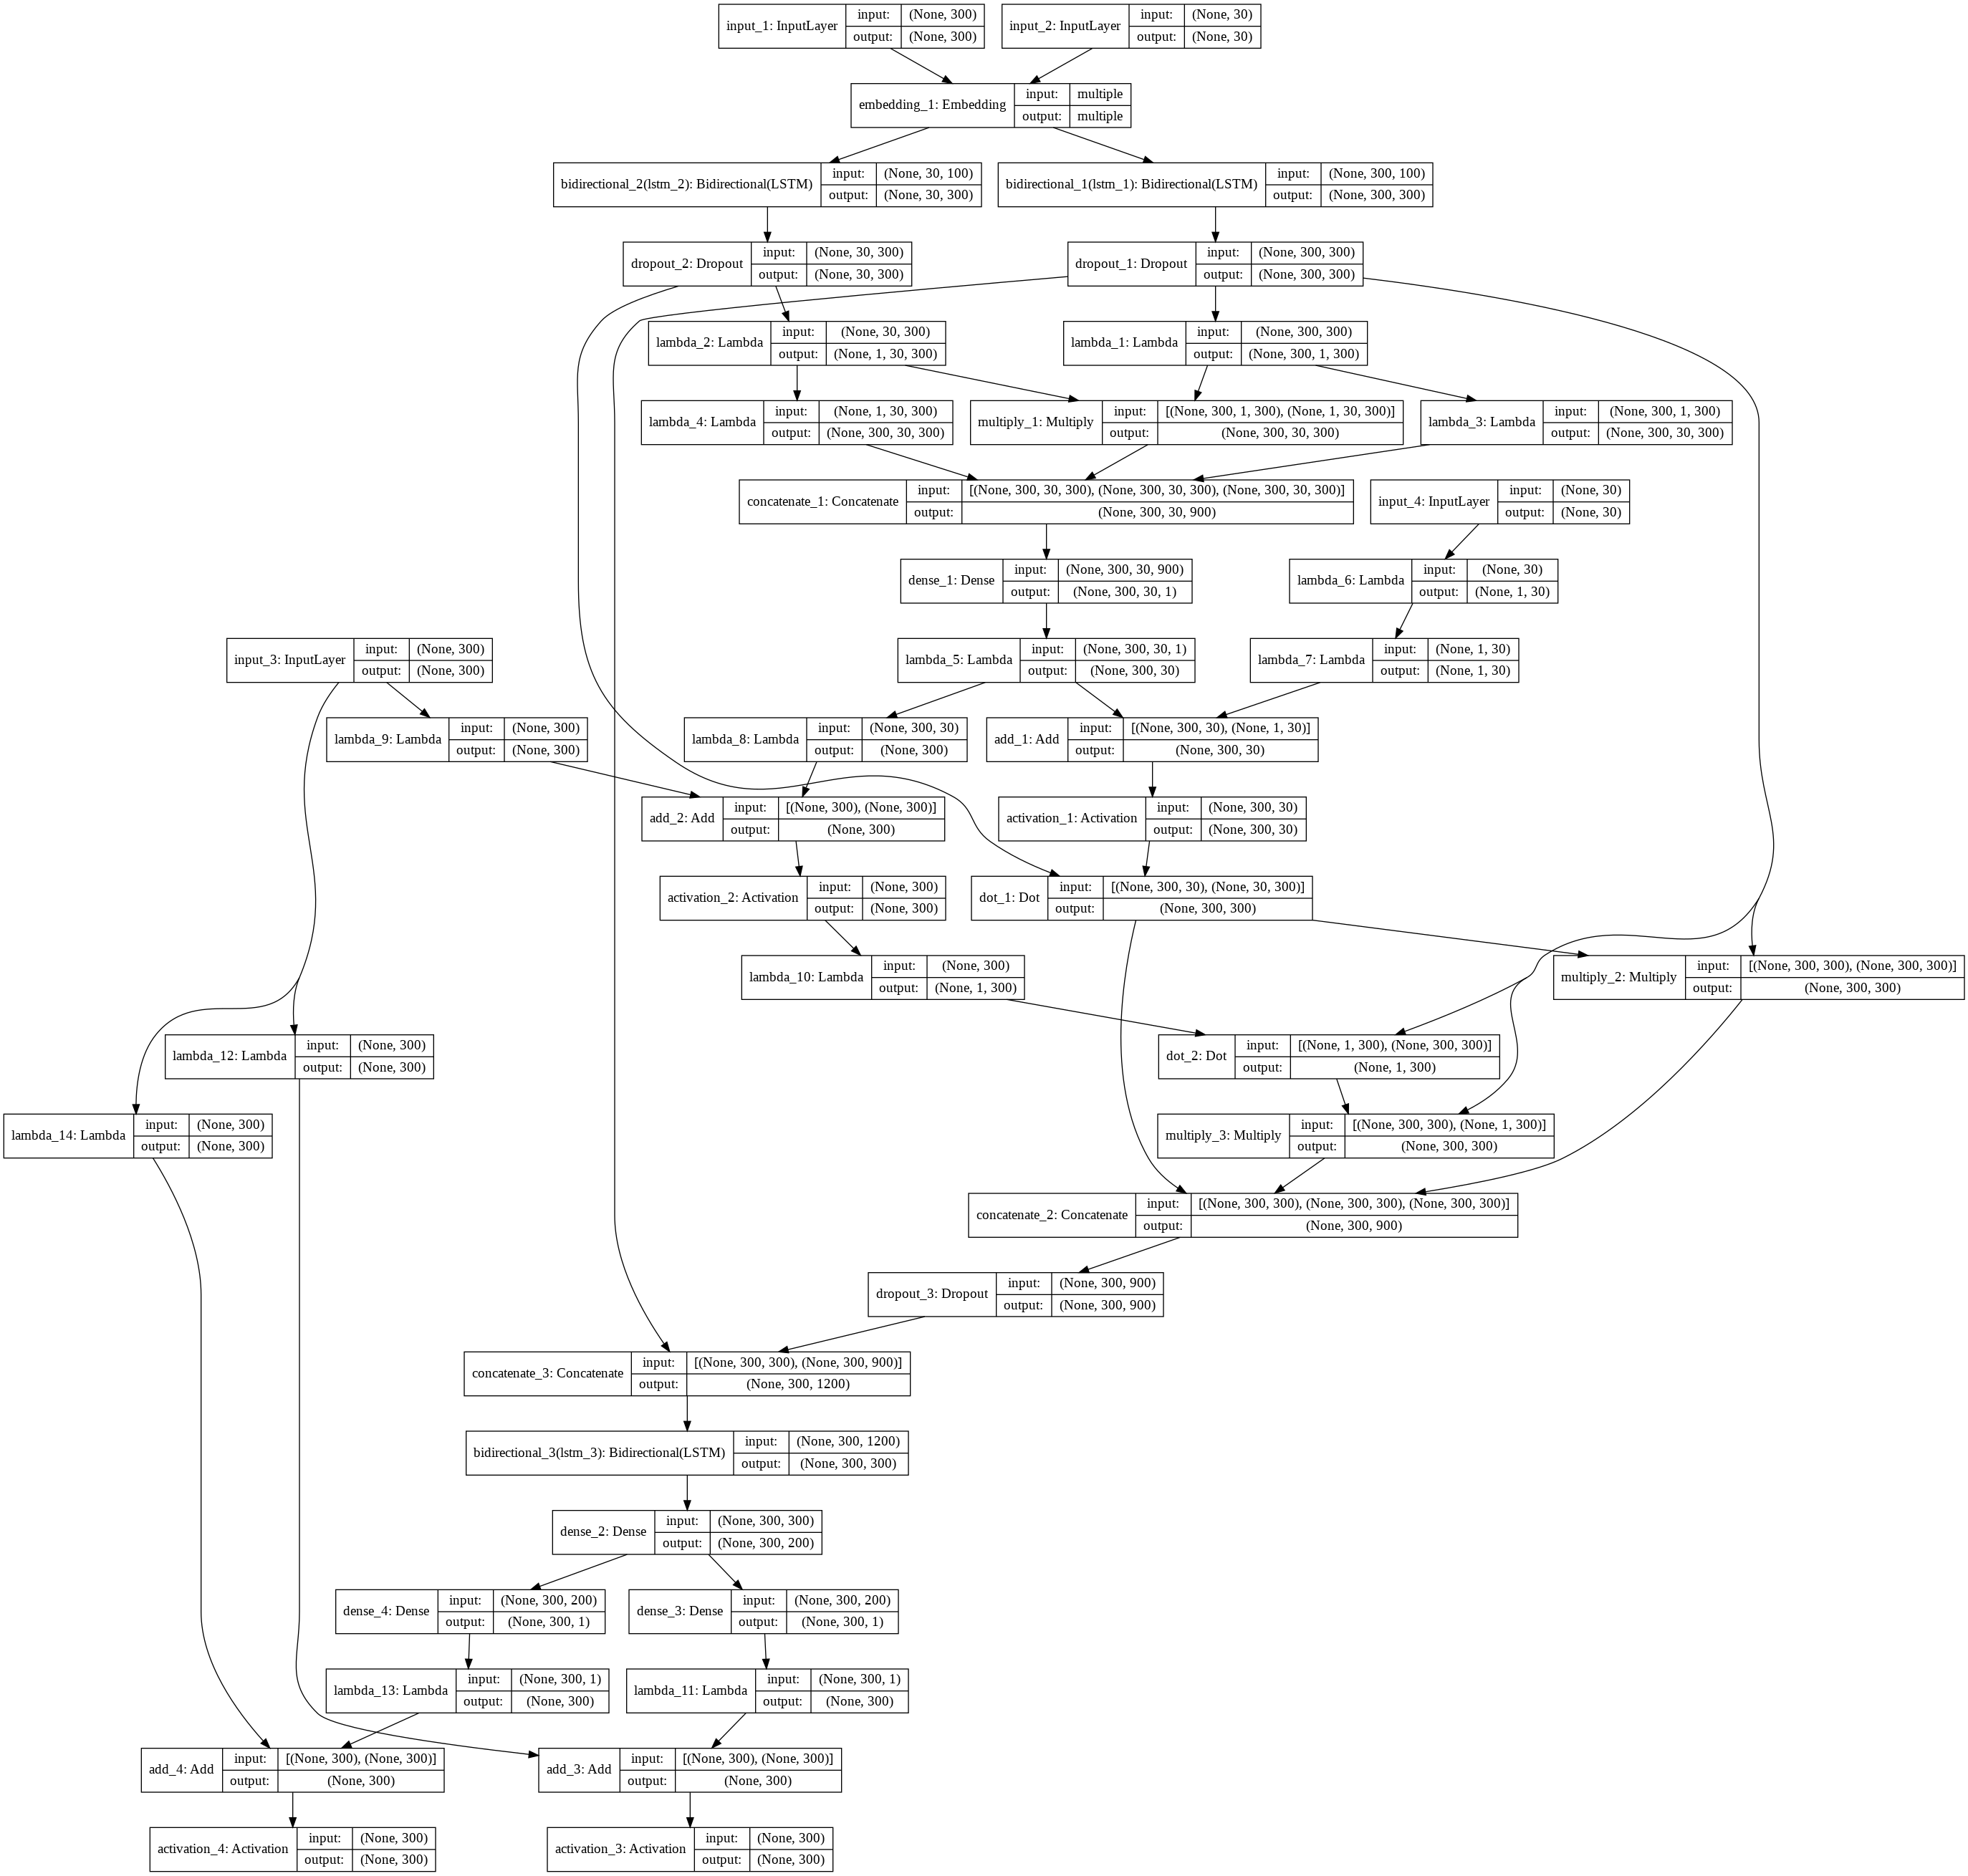

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model_part3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
#preparing the inputs to the enc_layer
ans_span_train=[v[6] for v in examples_train_set_mod]
train_context_ids=[v[0] for v in examples_train_set_mod]
train_que_ids=[v[3] for v in examples_train_set_mod]
train_context_masks=[v[1] for v in examples_train_set_mod]
train_que_masks=[v[4] for v in examples_train_set_mod]

train_context_ids=np.array(train_context_ids)
train_que_ids=np.array(train_que_ids)
train_context_masks=np.array(train_context_masks)
train_que_masks=np.array(train_que_masks)
ans_span_train=np.array(ans_span_train)

#print(train_context_ids.shape)
#print(train_que_ids.shape)

In [0]:
ans_span_start=ans_span_train[:,0]
ans_span_end=ans_span_train[:,1]
print(ans_span_start.shape)
print(ans_span_end.shape)

(86175,)
(86175,)


In [0]:
len_train=len(ans_span_start)
ans_span_start_ohc=np.zeros((len_train,300))
ans_span_end_ohc=np.zeros((len_train,300))
for i in range(len_train):
  v=ans_span_start[i]
  ans_span_start_ohc[i,v-1]=1
for i in range(len_train):
  v=ans_span_end[i]
  ans_span_end_ohc[i,v-1]=1

In [0]:
#model_part3.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['sparse_categorical_accuracy'])
model_part3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
print(train_context_ids.shape)
print(train_que_ids.shape)
print(train_context_masks.shape)
print(train_que_masks.shape)

(86175, 300)
(86175, 30)
(86175, 300)
(86175, 30)


In [0]:
print(ans_span_start_ohc.shape)

(86175, 300)


In [0]:
print(len_train)

86175


In [0]:
import random
batch_size=128
def gen(train_context_ids,train_que_ids,train_context_masks,train_que_masks,ans_span_start,ans_span_end):
  batch_train_context_ids=np.zeros((batch_size,context_len))
  batch_train_que_ids=np.zeros((batch_size,qn_len))
  batch_train_context_masks=np.zeros((batch_size,context_len))
  batch_train_que_masks=np.zeros((batch_size,qn_len))
  batch_ans_start=np.zeros((batch_size,context_len))
  batch_ans_end=np.zeros((batch_size,context_len))
  while True:
    for i in range(batch_size):
      v=np.random.choice(len_train)
      batch_train_context_ids[i]=train_context_ids[v]
      batch_train_que_ids[i]=train_que_ids[v]
      batch_train_context_masks[i]=train_context_masks[v]
      batch_train_que_masks[i]=train_que_masks[v]
      batch_ans_start[i]=ans_span_start[v]
      batch_ans_end[i]=ans_span_end[v]
    yield [batch_train_context_ids,batch_train_que_ids,batch_train_context_masks,batch_train_que_masks],[batch_ans_start,batch_ans_end]

In [0]:
#model_part3.fit_generator(gen(train_context_ids,train_que_ids,train_context_masks,train_que_masks,ans_span_start_ohc,ans_span_end_ohc),
                          #steps_per_epoch=250,
                          #epochs=20,verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
250/250 [==============================] - 1885s 8s/step - loss: 9.1430 - activation_3_loss: 4.6131 - activation_4_loss: 4.5298 - activation_3_acc: 0.0593 - activation_4_acc: 0.0607
Epoch 2/20
250/250 [==============================] - 302s 1s/step - loss: 8.3864 - activation_3_loss: 4.2625 - activation_4_loss: 4.1239 - activation_3_acc: 0.1179 - activation_4_acc: 0.1270
Epoch 3/20
250/250 [==============================] - 303s 1s/step - loss: 7.8038 - activation_3_loss: 3.8778 - activation_4_loss: 3.9259 - activation_3_acc: 0.1651 - activation_4_acc: 0.1707
Epoch 4/20
250/250 [==============================] - 301s 1s/step - loss: 7.2052 - activation_3_loss: 3.5958 - activation_4_loss: 3.6093 - activation_3_acc: 0.2024 - activation_4_acc: 0.2066
Epoch 5/20
250/250 [==============================] - 298s 1s/step - loss: 7.1171 - activation_3_loss: 3.5625 - activation_4_loss: 3.55

In [0]:
#model_part3.fit_generator(gen(train_context_ids,train_que_ids,train_context_masks,train_que_masks,ans_span_start_ohc,ans_span_end_ohc),
                          #steps_per_epoch=250,
                          #epochs=20,verbose=1)

Epoch 1/20
250/250 [==============================] - 298s 1s/step - loss: 4.3639 - activation_3_loss: 2.1481 - activation_4_loss: 2.2158 - activation_3_acc: 0.5218 - activation_4_acc: 0.5348
Epoch 2/20
250/250 [==============================] - 300s 1s/step - loss: 4.6322 - activation_3_loss: 2.2829 - activation_4_loss: 2.3493 - activation_3_acc: 0.5042 - activation_4_acc: 0.5196
Epoch 3/20
250/250 [==============================] - 301s 1s/step - loss: 4.3897 - activation_3_loss: 2.1809 - activation_4_loss: 2.2087 - activation_3_acc: 0.5211 - activation_4_acc: 0.5457
Epoch 4/20
250/250 [==============================] - 304s 1s/step - loss: 4.6574 - activation_3_loss: 2.2651 - activation_4_loss: 2.3923 - activation_3_acc: 0.5231 - activation_4_acc: 0.5307
Epoch 5/20
250/250 [==============================] - 305s 1s/step - loss: 4.2845 - activation_3_loss: 2.0659 - activation_4_loss: 2.2186 - activation_3_acc: 0.5473 - activation_4_acc: 0.5563
Epoch 6/20
250/250 [====================

In [0]:
#training from upto 60 epochs
'''model_part3.fit_generator(gen(train_context_ids,train_que_ids,train_context_masks,train_que_masks,ans_span_start_ohc,ans_span_end_ohc),
                          steps_per_epoch=250,
                          epochs=20,verbose=1)'''

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
250/250 [==============================] - 1803s 7s/step - loss: 3.8037 - activation_3_loss: 1.7576 - activation_4_loss: 2.0461 - activation_3_acc: 0.6281 - activation_4_acc: 0.6164
Epoch 2/20
250/250 [==============================] - 359s 1s/step - loss: 2.8588 - activation_3_loss: 1.3182 - activation_4_loss: 1.5406 - activation_3_acc: 0.6891 - activation_4_acc: 0.6897
Epoch 3/20
250/250 [==============================] - 360s 1s/step - loss: 3.8414 - activation_3_loss: 1.8092 - activation_4_loss: 2.0321 - activation_3_acc: 0.6164 - activation_4_acc: 0.6091
Epoch 4/20
250/250 [==============================] - 361s 1s/step - loss: 4.2001 - activation_3_loss: 1.9042 - activation_4_loss: 2.2959 - activation_3_acc: 0.6126 - activation_4_acc: 0.5854
Epoch 5/20
250/250 [==============================] - 361s 1s/step - loss: 3.6426 - activation_3_loss: 1.6951 - activation_4_loss: 1.94

In [0]:
model_part3.fit_generator(gen(train_context_ids,train_que_ids,train_context_masks,train_que_masks,ans_span_start_ohc,ans_span_end_ohc),
                          steps_per_epoch=250,
                          epochs=5,verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
250/250 [==============================] - 1723s 7s/step - loss: 3.5023 - activation_3_loss: 1.5979 - activation_4_loss: 1.9045 - activation_3_acc: 0.6859 - activation_4_acc: 0.6603
Epoch 2/5
250/250 [==============================] - 345s 1s/step - loss: 3.1605 - activation_3_loss: 1.3688 - activation_4_loss: 1.7917 - activation_3_acc: 0.7305 - activation_4_acc: 0.6911
Epoch 3/5
250/250 [==============================] - 344s 1s/step - loss: 3.2954 - activation_3_loss: 1.5248 - activation_4_loss: 1.7706 - activation_3_acc: 0.7062 - activation_4_acc: 0.6877
Epoch 4/5
250/250 [==============================] - 345s 1s/step - loss: 3.1445 - activation_3_loss: 1.4554 - activation_4_loss: 1.6891 - activation_3_acc: 0.7115 - activation_4_acc: 0.6923
Epoch 5/5
250/250 [==============================] - 345s 1s/step - loss: 3.2024 - activation_3_loss: 1.4683 - activation_4_loss: 1.7340 - 

In [0]:
model_part3.fit_generator(gen(train_context_ids,train_que_ids,train_context_masks,train_que_masks,ans_span_start_ohc,ans_span_end_ohc),
                          steps_per_epoch=250,
                          epochs=15,verbose=1)

Epoch 1/15
250/250 [==============================] - 350s 1s/step - loss: 2.6686 - activation_3_loss: 1.1714 - activation_4_loss: 1.4972 - activation_3_acc: 0.7453 - activation_4_acc: 0.7176
Epoch 2/15
250/250 [==============================] - 349s 1s/step - loss: 3.0605 - activation_3_loss: 1.4545 - activation_4_loss: 1.6059 - activation_3_acc: 0.7070 - activation_4_acc: 0.6953
Epoch 3/15
250/250 [==============================] - 349s 1s/step - loss: 2.7957 - activation_3_loss: 1.2781 - activation_4_loss: 1.5176 - activation_3_acc: 0.7326 - activation_4_acc: 0.7146
Epoch 4/15
250/250 [==============================] - 349s 1s/step - loss: 2.8467 - activation_3_loss: 1.3333 - activation_4_loss: 1.5134 - activation_3_acc: 0.7368 - activation_4_acc: 0.7213
Epoch 5/15
 13/250 [>.............................] - ETA: 5:28 - loss: 2.3868 - activation_3_loss: 1.1898 - activation_4_loss: 1.1970 - activation_3_acc: 0.7524 - activation_4_acc: 0.7482

In [0]:
maxprod = 0
chosen_start = 0
chosen_end = 0
for i in range(context_len-16):
    end_dist_subset = end_dist[0,i:i+16]
    end_prob_max = np.amax(end_dist_subset)
    end_idx = np.argmax(end_dist_subset)
    start_prob = start_dist[0,i]
    prod = end_prob_max*start_prob
    # print("Prod: ", prod)

  # print("Shape end, start:", end_prob_max.shape, start_prob.shape)

    if prod > maxprod:
        maxprod = prod
        chosen_start = i
        chosen_end = chosen_start+end_idx

start_pos = chosen_start
# end_idx = np.argmax(end_dist[j:chosen_start:chosen_start+16])
# print("Chosen end", chosen_start+end_idx)
end_pos = chosen_end
maxprob = round(maxprod,4)

In [0]:
np.random.choice(len(train_context_ids))
train_len=len(train_context_ids)

In [0]:
from collections import Counter
import string
import re
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

In [0]:
def predict2(train_context_ids,train_que_ids,train_context_masks,train_que_masks,ans_span_start,ans_span_end):
  f1_total=0.0
  for j in range(1000):
    i=np.random.choice(train_len)
    sample=[]
    sample.append(train_context_ids[i,:].reshape(1,300))
    sample.append(train_que_ids[i,:].reshape(1,30))
    sample.append(train_context_masks[i,:].reshape(1,300))
    sample.append(train_que_masks[i,:].reshape(1,30))

    true_ans=[]
    true_ans.append(ans_span_start[i])
    true_ans.append(ans_span_end[i])

    start_dist,end_dist=model_part3.predict(sample)

    '''maxprod = 0
    chosen_start = 0
    chosen_end = 0
    for k in range(context_len-16):
        end_dist_subset = end_dist[0,k:k+16]
        end_prob_max = np.amax(end_dist_subset)
        end_idx = np.argmax(end_dist_subset)
        start_prob = start_dist[0,k]
        prod = end_prob_max*start_prob
    # print("Prod: ", prod)

  # print("Shape end, start:", end_prob_max.shape, start_prob.shape)

        if prod > maxprod:
            maxprod = prod
            chosen_start = i
            chosen_end = chosen_start+end_idx

    start_pos = chosen_start
    # end_idx = np.argmax(end_dist[j:chosen_start:chosen_start+16])
    # print("Chosen end", chosen_start+end_idx)
    end_pos = chosen_end
    maxprob = round(maxprod,4)'''

    start_pos = np.argmax(start_dist, axis=1)
    end_pos = np.argmax(end_dist, axis=1)

    true_ans=train_context_tokens[i][true_ans[0]:true_ans[1]+1]
    true_ans=" ".join(true_ans)

    pred_ans=train_context_tokens[i][start_pos[0]:end_pos[0]+1]
    pred_ans=" ".join(pred_ans)

    f1=f1_score(pred_ans, true_ans)
    f1_total+=f1

    if (j%100==0):
      print(pred_ans)
      print(true_ans)
      print(f1_total/(j+1))
  f1_total/=1000.00
  return f1_total


In [0]:
print(predict2(train_context_ids,train_que_ids,train_context_masks,train_que_masks,ans_span_start,ans_span_end))

as coastal
coastal somali
0.5
, present-day
nepal
0.35541462541546676
of
mgm
0.3835851976447364
along the coast of
along the coast of samar
0.40056538146610576
the spiritual
spiritual intermediaries
0.39354241430164455
the proclamation of 1763 restricted settlement for great britain 's thirteen original colonies in north america to east of the summit line of the
the proclamation of 1763 restricted settlement for great britain 's thirteen original colonies in north america to east of the summit line of the mountains
0.3874680168268066
. while many americans may be biologically multiracial , they often do not know it or do not identify so
while many americans may be biologically multiracial , they often do not know it
0.38982132752509363
on 31 october
31 october 1517
0.393913966096124
of two separate satellite
two separate satellite constellations
0.4013333636805752
containing
aluminium
0.40357702146137364
0.4010436673785218
